In [1]:
!pip install tensorflow


RAM available: 11.01 GB
Found 396 images belonging to 3 classes.
Found 97 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.4536 - loss: 1.2783 - precision: 0.4547 - recall: 0.3837 - val_accuracy: 0.4948 - val_loss: 1.2394 - val_precision: 0.5405 - val_recall: 0.4124 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.7404 - loss: 0.6492 - precision: 0.8142 - recall: 0.6755 - val_accuracy: 0.5155 - val_loss: 1.0867 - val_precision: 0.6000 - val_recall: 0.4639 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.8442 - loss: 0.5041 - precision: 0.8717 - recall: 0.7836 - val_accuracy: 0.5361 - val_loss: 1.0696 - val_precision: 0.6049 - val_recall: 0.5052 - learning_rate: 1.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.8300 - loss: 0.5019 - precision: 0.8641 - recall: 0.7724 - val_accuracy: 0.5979 - val_loss: 0.9448 - val_precision: 0.6386 - val_recall: 0.5464 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms

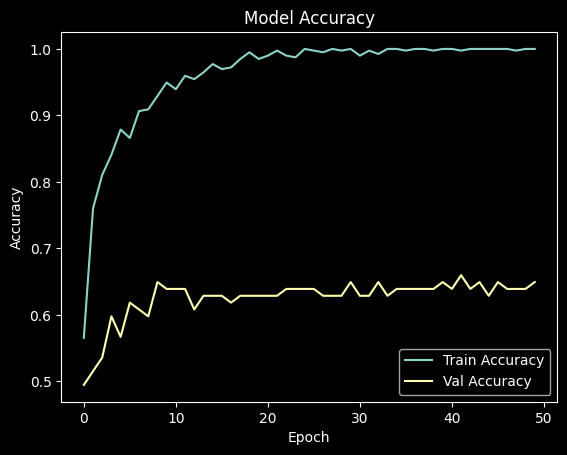

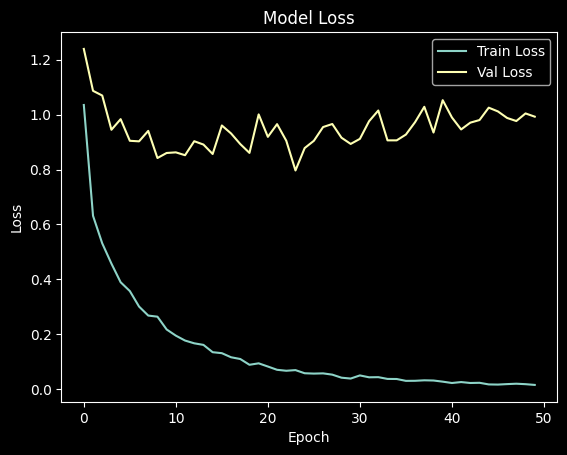

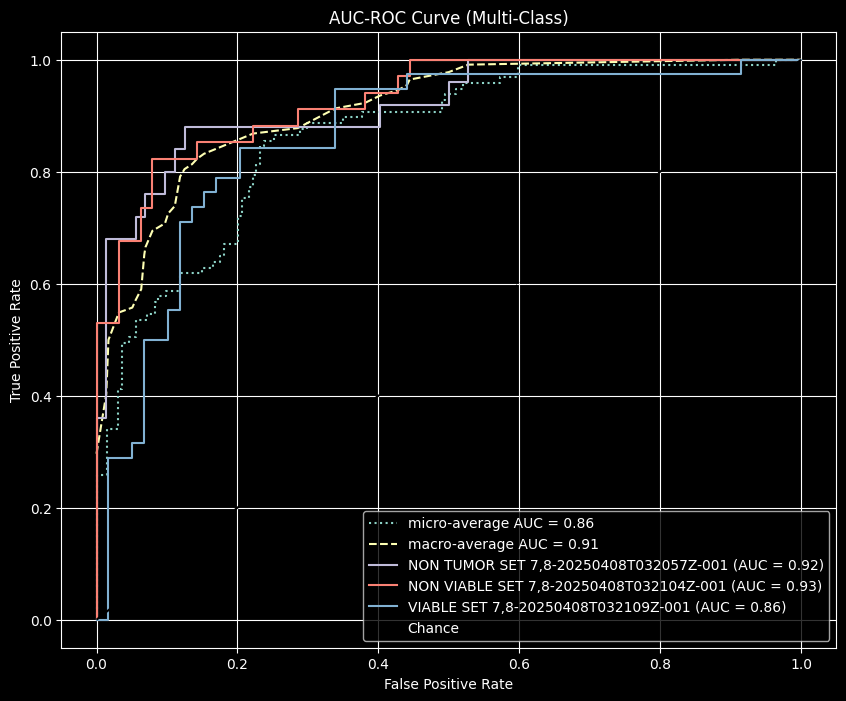

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
95.36% confidence this is VIABLE SET 7,8-20250408T032109Z-001
Predicted Severity: Severe


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


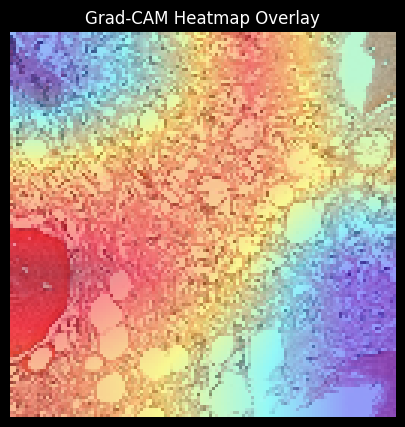

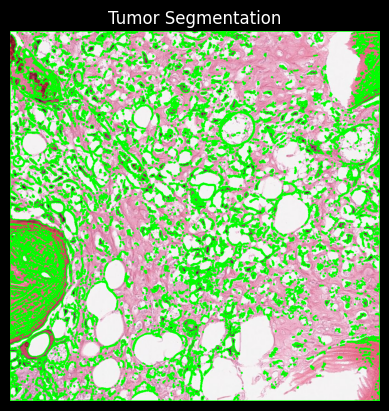

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import psutil

# System info
plt.style.use('dark_background')
print(f"RAM available: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

# Paths and parameters
data_dir = "/content/drive/MyDrive/cancerdataset"
img_size = (128, 128)
batch_size = 8

# Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False)

class_names = list(train_data.class_indices.keys())

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Build model
def build_model():
    base = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(3, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=45, min_lr=1e-6)

# Train
history = model.fit(train_data, validation_data=val_data, epochs=50,
                    class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# Evaluate
loss, acc, prec, rec = model.evaluate(val_data)
print(f"Loss: {loss:.4f} | Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}%")

# Predictions
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Accuracy and loss plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AUC-ROC
def plot_auc_roc(y_true, y_pred, class_names):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', label='micro-average AUC = {:.2f}'.format(roc_auc["micro"]))
    plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label='macro-average AUC = {:.2f}'.format(roc_auc["macro"]))

    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve (Multi-Class)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_auc_roc(y_true, y_pred, class_names)

# Tumor segmentation
def segment_tumor(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Segmentation')
    plt.axis('off')
    plt.show()

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap Overlay')
    plt.axis('off')
    plt.show()

# Predict + Segment + Explain
def predict_and_segment(image_path):
    img = Image.open(image_path).resize(img_size).convert("RGB")
    arr = np.array(img) / 255.0
    arr = arr.reshape(1, img_size[0], img_size[1], 3)

    res = model.predict(arr)
    class_idx = np.argmax(res[0])
    confidence = res[0][class_idx]
    severity = "Severe" if confidence > 0.8 else "Moderate" if confidence > 0.5 else "Mild"

    print(f"{confidence*100:.2f}% confidence this is {class_names[class_idx]}")
    print(f"Predicted Severity: {severity}")

    heatmap = make_gradcam_heatmap(arr, model)
    display_gradcam(image_path, heatmap)
    segment_tumor(image_path)

# Test with an image
predict_and_segment("/content/Case-48-P5-C23-28780-10637.jpg")


RAM available: 9.85 GB
Found 396 images belonging to 3 classes.
Found 97 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.4995 - loss: 1.1872 - precision: 0.5013 - recall: 0.4033 - val_accuracy: 0.4742 - val_loss: 1.3023 - val_precision: 0.4568 - val_recall: 0.3814 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.6923 - loss: 0.7194 - precision: 0.7287 - recall: 0.6007 - val_accuracy: 0.5052 - val_loss: 1.1540 - val_precision: 0.5238 - val_recall: 0.4536 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.7896 - loss: 0.5459 - precision: 0.8442 - recall: 0.7324 - val_accuracy: 0.5258 - val_loss: 1.1215 - val_precision: 0.5294 - val_recall: 0.4639 - learning_rate: 1.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8266 - loss: 0.4967 - precision: 0.8936 - recall: 0.7743 - val_accuracy: 0.5567 - val_loss: 1.0188 - val_precision: 0.5647 - val_recall: 0.4948 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 21

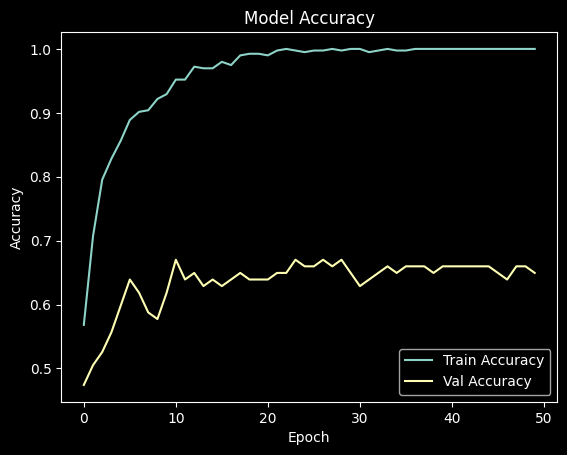

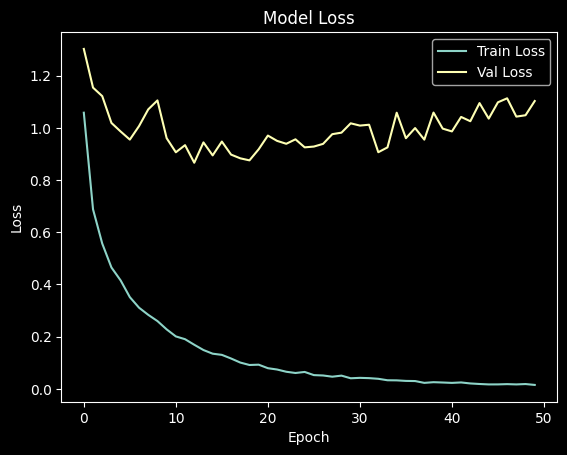

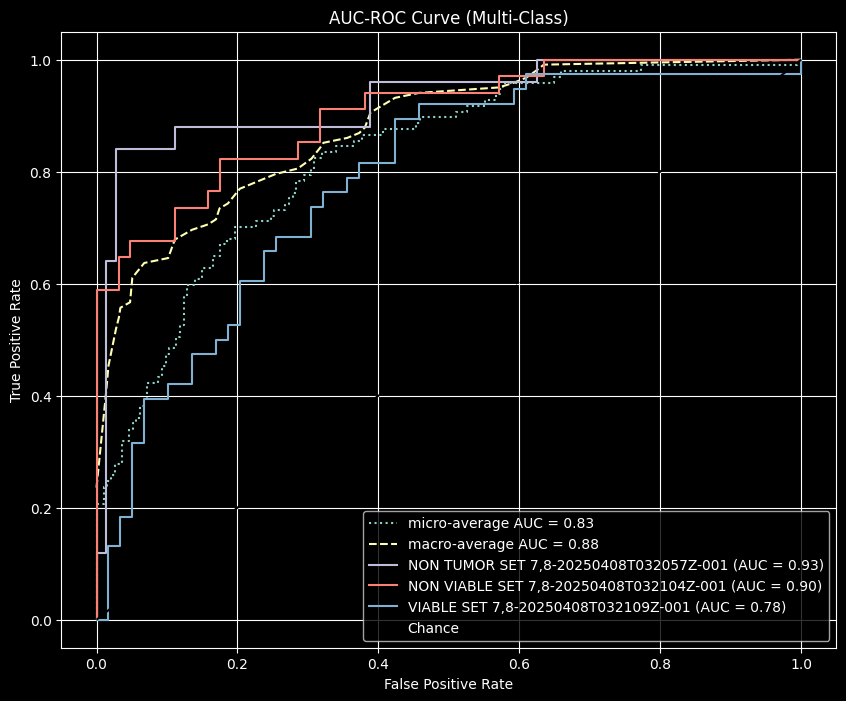

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
98.80% confidence this is NON TUMOR SET 7,8-20250408T032057Z-001
Predicted Severity: Severe


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_363']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


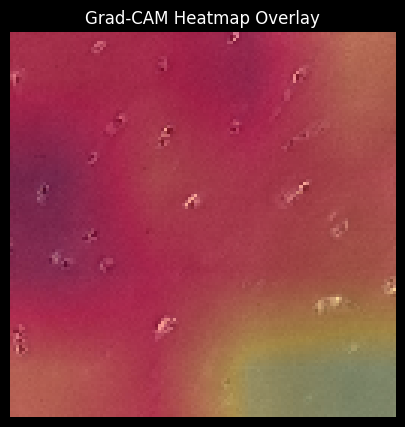

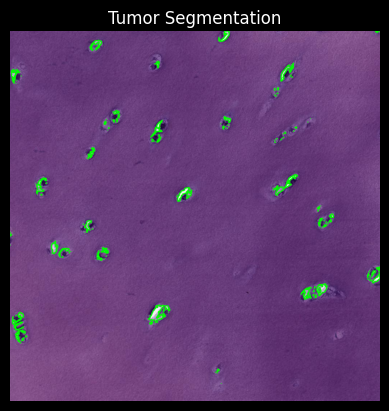

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import psutil

# System info
plt.style.use('dark_background')
print(f"RAM available: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

# Paths and parameters
data_dir = "/content/drive/MyDrive/cancerdataset"
img_size = (128, 128)
batch_size = 8

# Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False)

class_names = list(train_data.class_indices.keys())

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Build model
def build_model():
    base = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(3, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=45, min_lr=1e-6)

# Train
history = model.fit(train_data, validation_data=val_data, epochs=50,
                    class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# Evaluate
loss, acc, prec, rec = model.evaluate(val_data)
print(f"Loss: {loss:.4f} | Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}%")

# Predictions
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Accuracy and loss plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AUC-ROC
def plot_auc_roc(y_true, y_pred, class_names):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', label='micro-average AUC = {:.2f}'.format(roc_auc["micro"]))
    plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label='macro-average AUC = {:.2f}'.format(roc_auc["macro"]))

    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve (Multi-Class)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_auc_roc(y_true, y_pred, class_names)

# Tumor segmentation
def segment_tumor(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Segmentation')
    plt.axis('off')
    plt.show()

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap Overlay')
    plt.axis('off')
    plt.show()

# Predict + Segment + Explain
def predict_and_segment(image_path):
    img = Image.open(image_path).resize(img_size).convert("RGB")
    arr = np.array(img) / 255.0
    arr = arr.reshape(1, img_size[0], img_size[1], 3)

    res = model.predict(arr)
    class_idx = np.argmax(res[0])
    confidence = res[0][class_idx]
    severity = "Severe" if confidence > 0.8 else "Moderate" if confidence > 0.5 else "Mild"

    print(f"{confidence*100:.2f}% confidence this is {class_names[class_idx]}")
    print(f"Predicted Severity: {severity}")

    heatmap = make_gradcam_heatmap(arr, model)
    display_gradcam(image_path, heatmap)
    segment_tumor(image_path)

# Test with an image
predict_and_segment("/content/Case-48-P5-C23-10747-20258.jpg")


RAM available: 9.80 GB
Found 396 images belonging to 3 classes.
Found 97 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 264ms/step - accuracy: 0.3316 - loss: 1.5179 - precision: 0.3361 - recall: 0.2604 - val_accuracy: 0.4639 - val_loss: 1.2162 - val_precision: 0.5063 - val_recall: 0.4124 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.7107 - loss: 0.6970 - precision: 0.7719 - recall: 0.6446 - val_accuracy: 0.4742 - val_loss: 1.1749 - val_precision: 0.5385 - val_recall: 0.4330 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.7253 - loss: 0.6110 - precision: 0.7800 - recall: 0.6978 - val_accuracy: 0.4639 - val_loss: 1.0955 - val_precision: 0.5176 - val_recall: 0.4536 - learning_rate: 1.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.8036 - loss: 0.4825 - precision: 0.8562 - recall: 0.7670 - val_accuracy: 0.4742 - val_loss: 1.0353 - val_precision: 0.5500 - val_recall: 0.4536 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 18

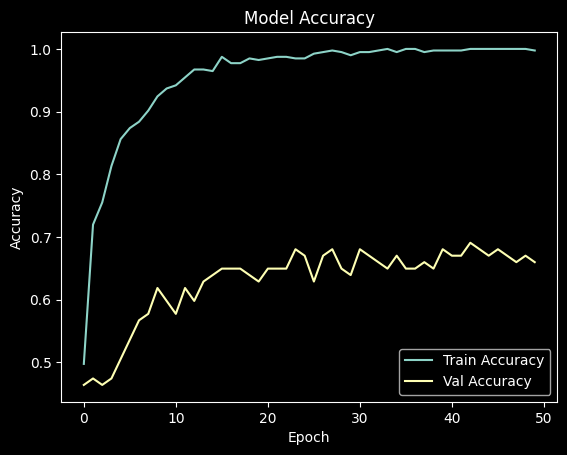

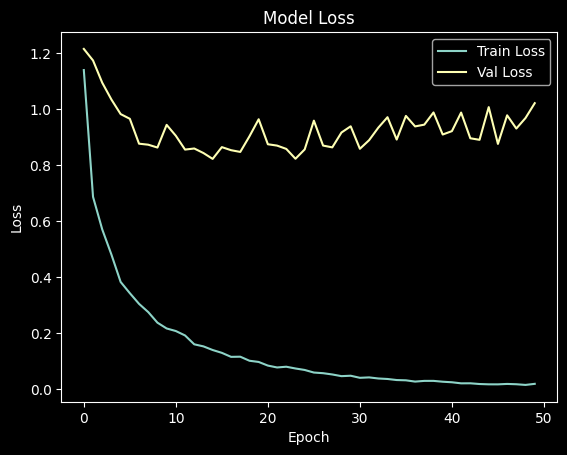

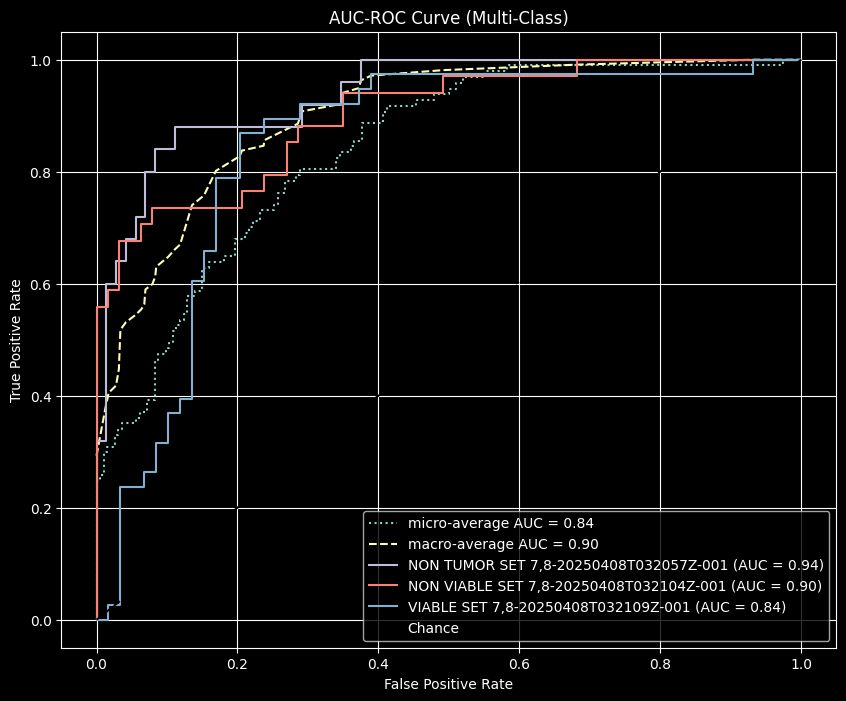

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
95.85% confidence this is VIABLE SET 7,8-20250408T032109Z-001
Predicted Severity: Severe


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_837']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


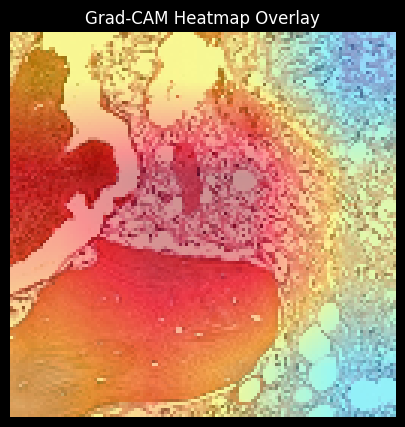

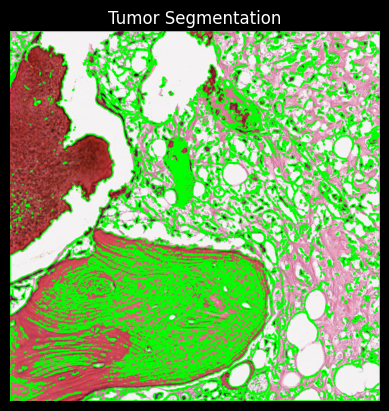

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import psutil

# System info
plt.style.use('dark_background')
print(f"RAM available: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

# Paths and parameters
data_dir = "/content/drive/MyDrive/cancerdataset"
img_size = (128, 128)
batch_size = 8

# Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False)

class_names = list(train_data.class_indices.keys())

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Build model
def build_model():
    base = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(3, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=45, min_lr=1e-6)

# Train
history = model.fit(train_data, validation_data=val_data, epochs=50,
                    class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# Evaluate
loss, acc, prec, rec = model.evaluate(val_data)
print(f"Loss: {loss:.4f} | Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}%")

# Predictions
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Accuracy and loss plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AUC-ROC
def plot_auc_roc(y_true, y_pred, class_names):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', label='micro-average AUC = {:.2f}'.format(roc_auc["micro"]))
    plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label='macro-average AUC = {:.2f}'.format(roc_auc["macro"]))

    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve (Multi-Class)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_auc_roc(y_true, y_pred, class_names)

# Tumor segmentation
def segment_tumor(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Segmentation')
    plt.axis('off')
    plt.show()

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap Overlay')
    plt.axis('off')
    plt.show()

# Predict + Segment + Explain
def predict_and_segment(image_path):
    img = Image.open(image_path).resize(img_size).convert("RGB")
    arr = np.array(img) / 255.0
    arr = arr.reshape(1, img_size[0], img_size[1], 3)

    res = model.predict(arr)
    class_idx = np.argmax(res[0])
    confidence = res[0][class_idx]
    severity = "Severe" if confidence > 0.8 else "Moderate" if confidence > 0.5 else "Mild"

    print(f"{confidence*100:.2f}% confidence this is {class_names[class_idx]}")
    print(f"Predicted Severity: {severity}")

    heatmap = make_gradcam_heatmap(arr, model)
    display_gradcam(image_path, heatmap)
    segment_tumor(image_path)

# Test with an image
predict_and_segment("/content/Case-48-P5-C21-28225-10553.jpg")
